### How to project the 3D arm onto the camera plane?

In [1]:
from projectyl.dynamics.armmodel import ArmRobot
from projectyl.dynamics.meshcat_viewer_wrapper import MeshcatVisualizer
from projectyl.utils.camera_projection import project_3D_point, get_intrinic_matrix, get_4D_homogeneous_vector, get_focal_from_full_frame_equivalent, rescale_focal
from projectyl.dynamics.inverse_kinematics import forward_kinematics
import cv2 as cv
import matplotlib.pyplot as plt
import pinocchio as pin
import numpy as np
from projectyl.utils.properties import COLOR, POSITION, SIZE, ELBOW, SHOULDER, WRIST
%load_ext autoreload
%autoreload 2
def make_a_scene_in_3D(object_list, viz: MeshcatVisualizer = None) -> MeshcatVisualizer:
    """Make the 3D scene with the given objects in Meshcat

    Args:
        object_list (List[dict]): _description_
        viz (MeshcatVisualizer, optional): _description_. Defaults to None.
    """
    if viz is None:
        viz = MeshcatVisualizer()
    for name, obj in object_list.items():
        viz.addBox(
            name,
            obj[SIZE],
            obj[COLOR]
        )
        viz.applyConfiguration(name, pin.SE3(np.eye(3), np.array(obj[POSITION])))
    return viz


In [2]:
arm = ArmRobot(0.35, 0.3)
viz = MeshcatVisualizer(robot=arm)
viz.display(arm.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


In [3]:
q = pin.randomConfiguration(arm.model)
viz.display(q)

In [4]:
object_list = {
    CAMERA: {
        COLOR: [1., 0.5, 0.5, 1.],
        POSITION: [0.1, -1.6, 0.8],
        SIZE: [0.05, 0.2, 0.05]
    }
}
make_a_scene_in_3D(object_list, viz)

In [5]:
w, h = 1920, 1080 # Full HD 1080p
fpix = rescale_focal(
    fpix=get_focal_from_full_frame_equivalent(), 
    w_resized=1920
)
k = get_intrinic_matrix((h, w), fpix)

extrinsic_matrix = np.zeros((3, 4))
extrinsic_matrix[:3, :3] = np.eye(3)
cam_pos = get_4D_homogeneous_vector(object_list[CAMERA][POSITION])
extrinsic_matrix[:3, -1] = -cam_pos[:3, 0]


In [6]:
p2d_list = {}
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
    point, jac = forward_kinematics(arm, q, frame=frame)
    p3d = point.translation
    p2d = project_3D_point(p3d, k, extrinsic_matrix)
    p2d_list[frame] = {"2d": p2d, COLOR: colors[frame_idx]}

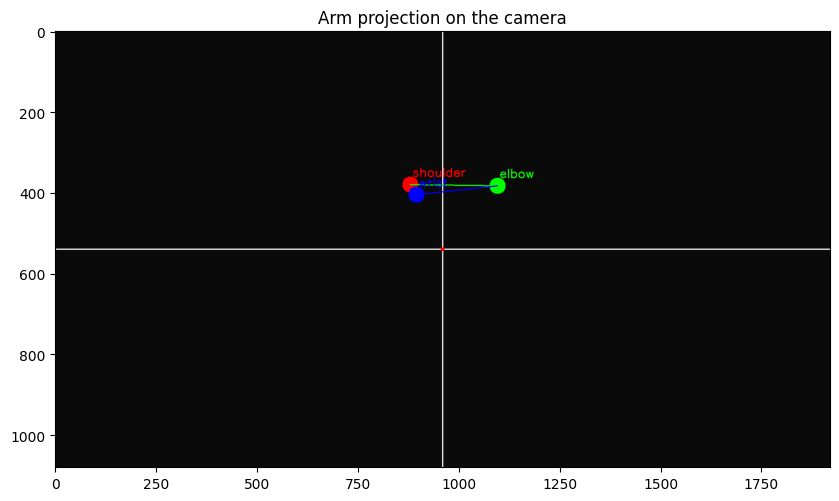

In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
img = 10*np.ones((h, w, 3))  # 720p frame
cv.line(img, (0, h//2), (w, h//2), (255, 255, 255), 2)
cv.line(img, (w//2, 0), (w//2, h), (255, 255, 255), 2)
cv.circle(img, (w//2, h//2), 5, (255, 0, 0), -1)
for frame_idx, frame in enumerate(p2d_list):
    p2d = p2d_list[frame]["2d"]
    cv.circle(img, (int(p2d[0]), int(p2d[1])), 20, p2d_list[frame][COLOR], -1)
    cv.putText(
            img,
            f"{frame}",
            (int(p2d[0]+5), int(p2d[1])-20),
            cv.FONT_HERSHEY_SIMPLEX,
            1,
            p2d_list[frame][COLOR],
            2,
            cv.LINE_AA
    )
    if frame_idx>0:
        p2d_prev = p2d_list[list(p2d_list.keys())[frame_idx-1]]["2d"]
        cv.line(
            img,
            (int(p2d[0]), int(p2d[1])),
            (int(p2d_prev[0]), int(p2d_prev[1])),
            p2d_list[frame][COLOR], 2
        )

img = img.clip(0, 255).astype(np.uint8)
plt.title("Arm projection on the camera")
plt.imshow(img)
plt.show()